In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def insert_empty_rows(df, init, end):
    blank_years = list(range(init, end))
    empty_rows = [pd.DataFrame({'Year': [year] + [''] * (df.shape[1] - 1)}) for year in blank_years]
    df = pd.concat([pd.DataFrame({'Year': [year]}) for year in years_to_insert] + [df], ignore_index=True)
    df = df.sort_values(by='Year').reset_index(drop=True)

    return df

In [7]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 3) #3 meses
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

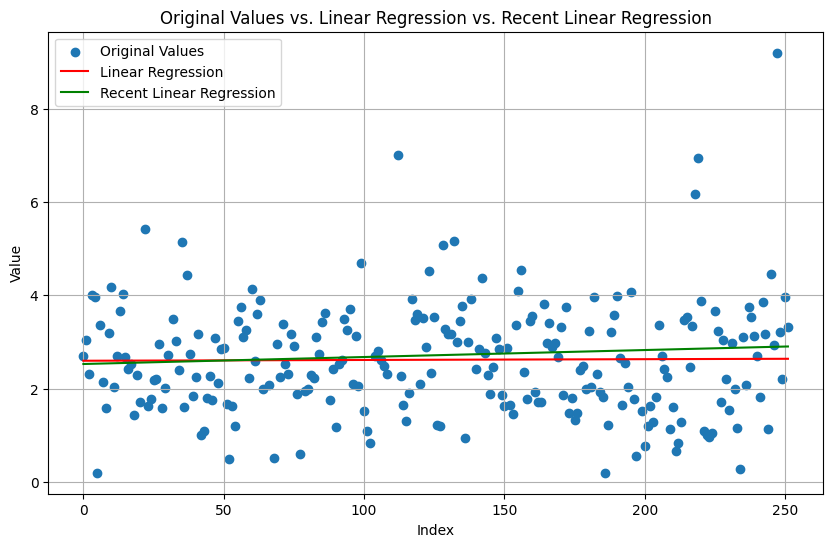

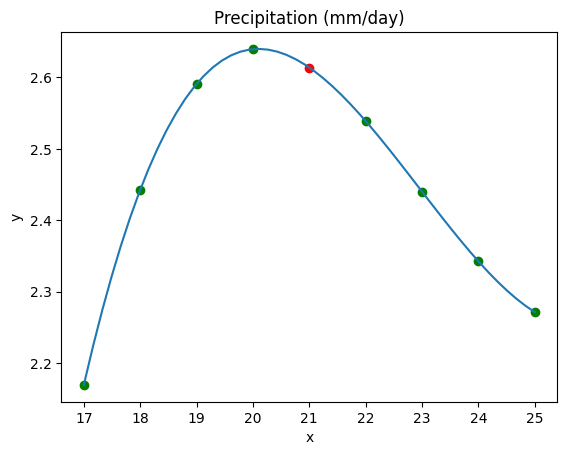

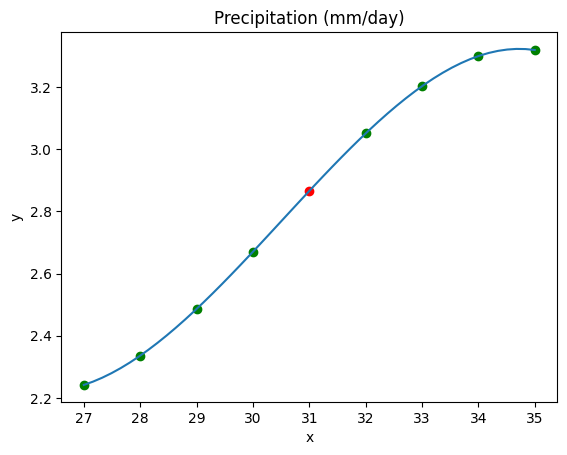

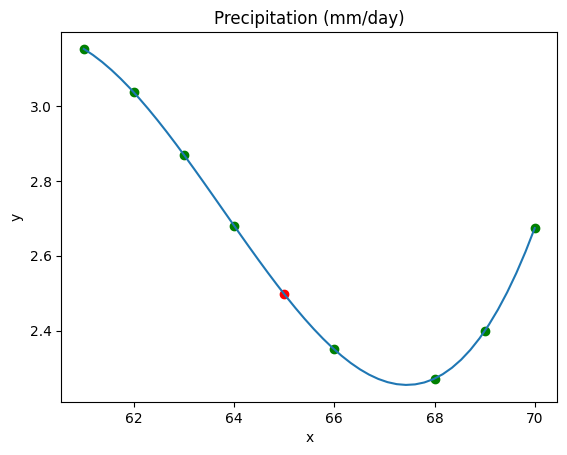

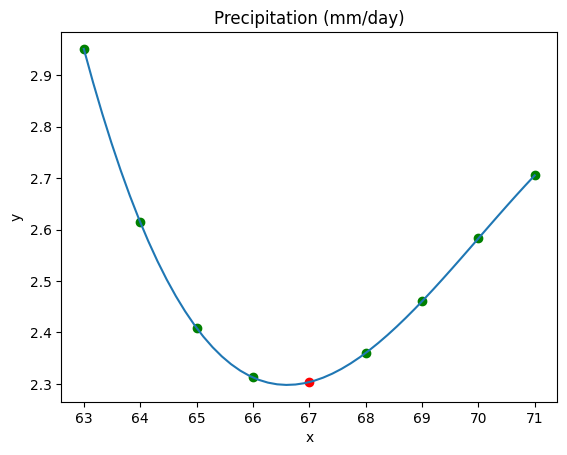

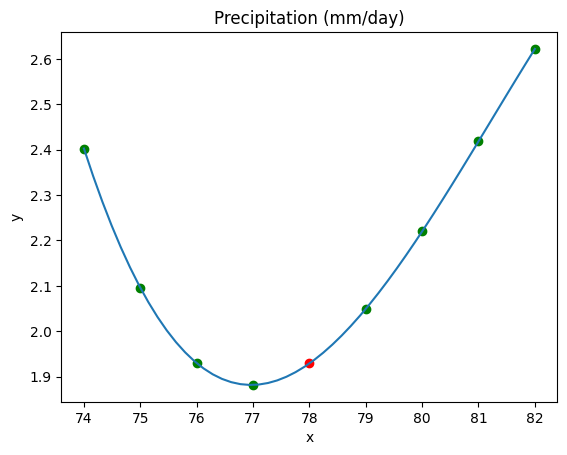

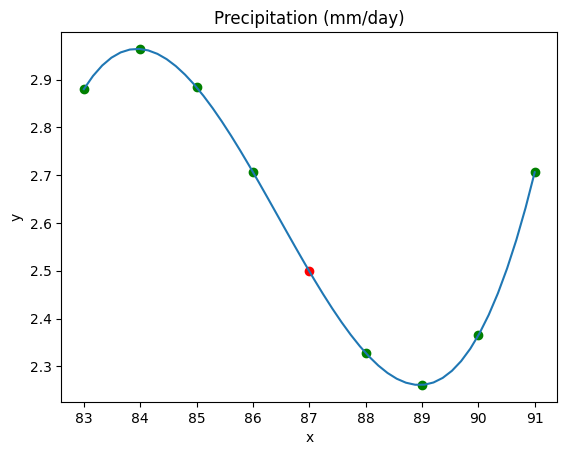

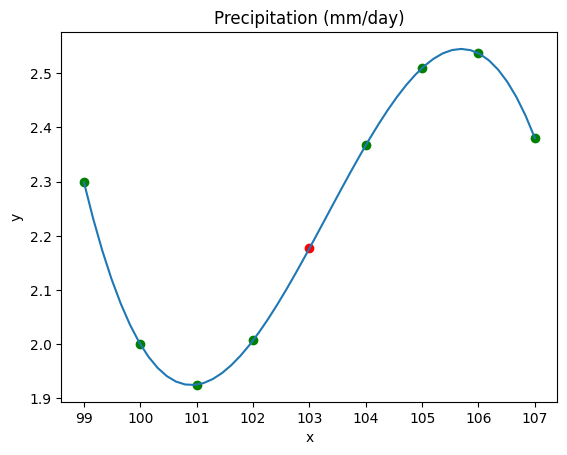

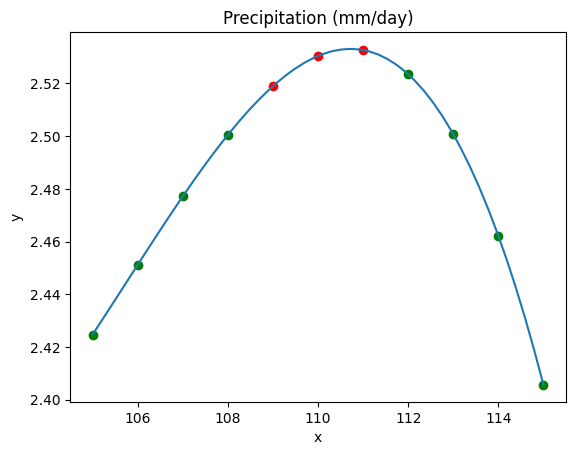

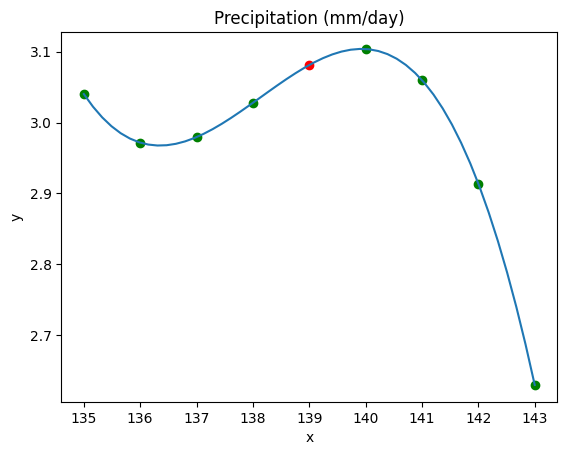

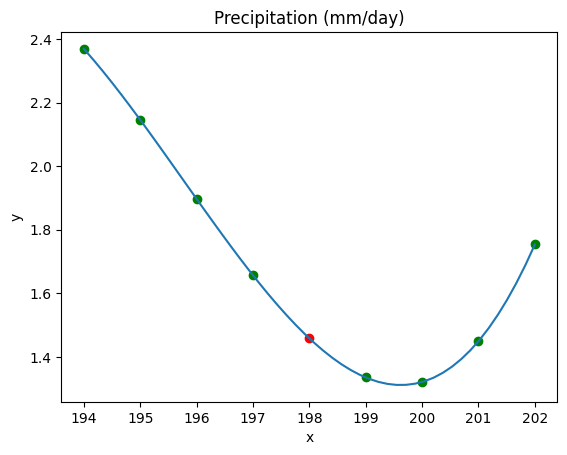

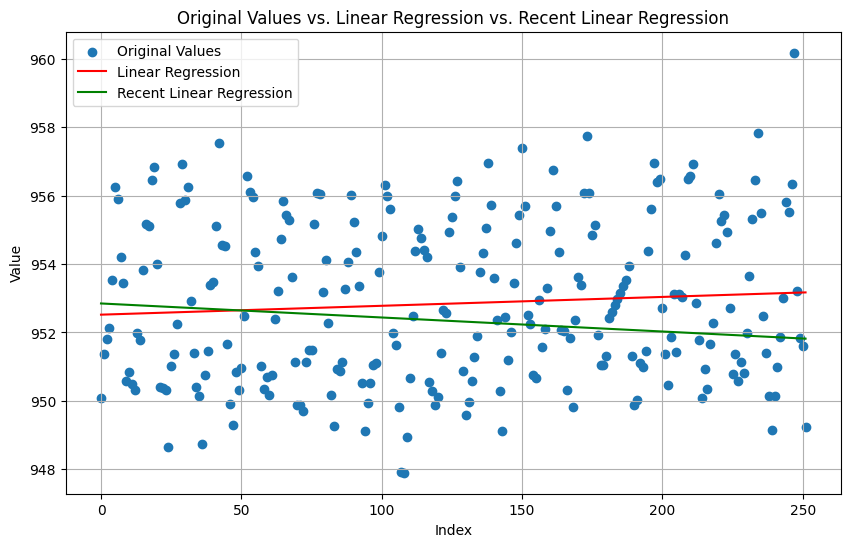

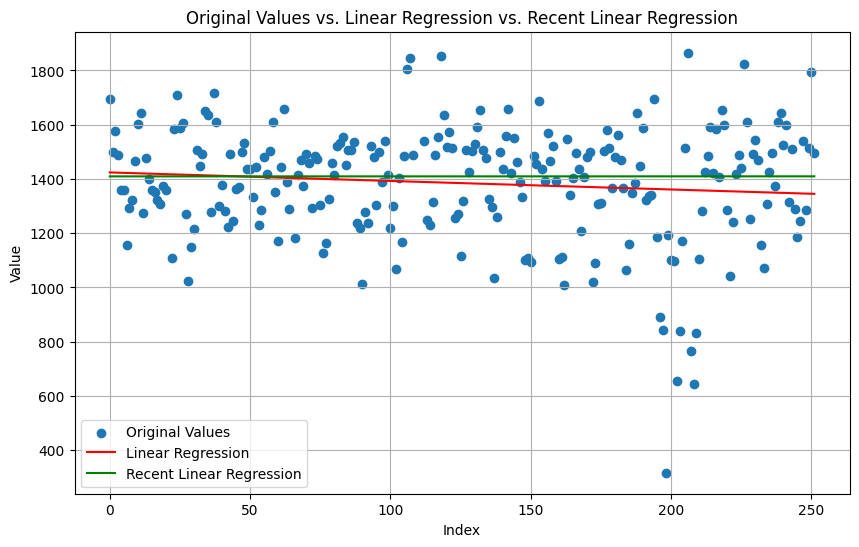

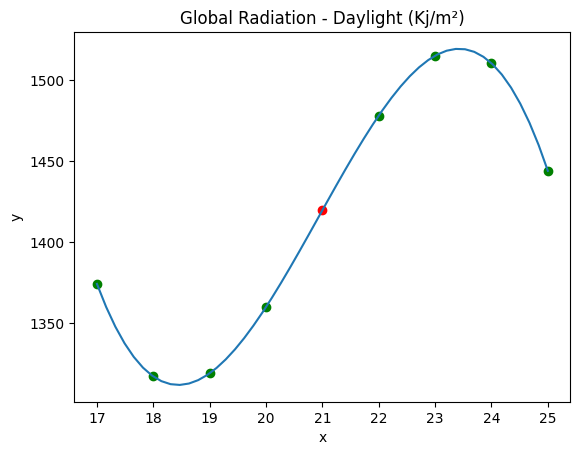

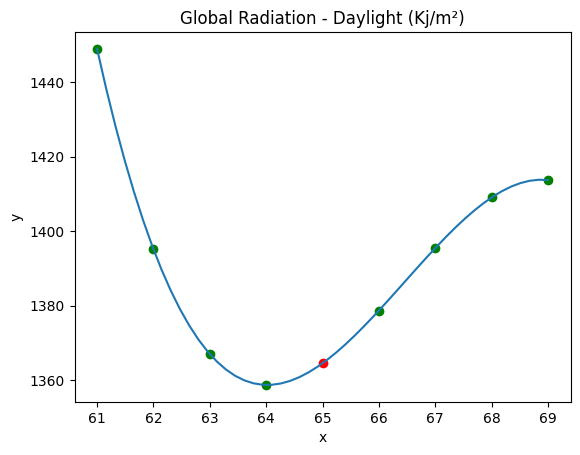

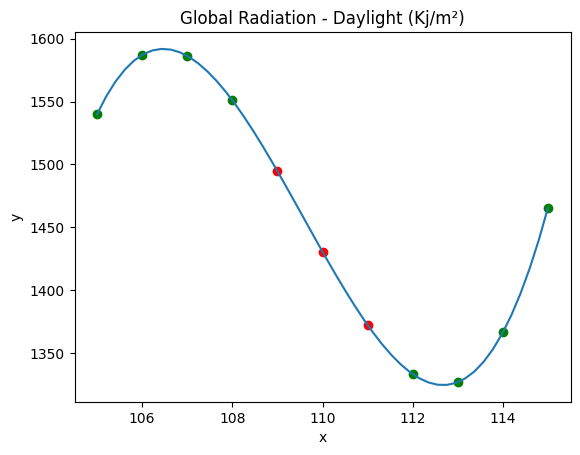

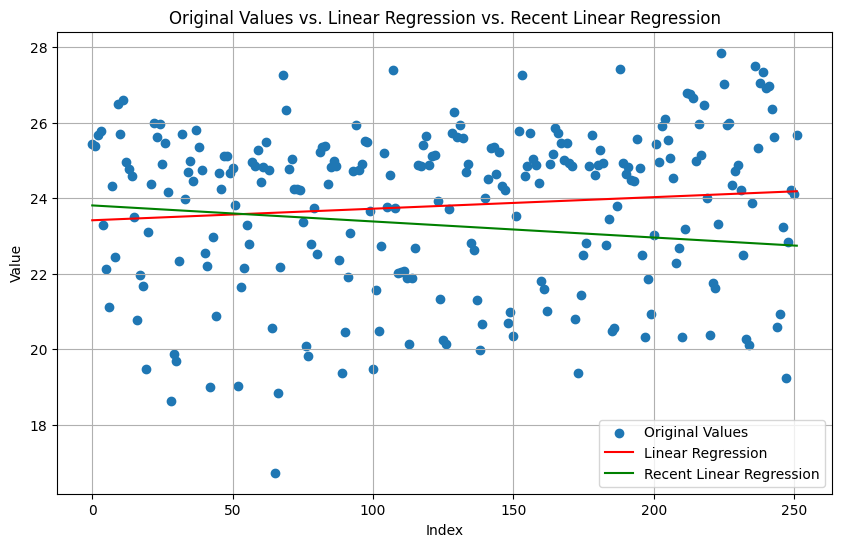

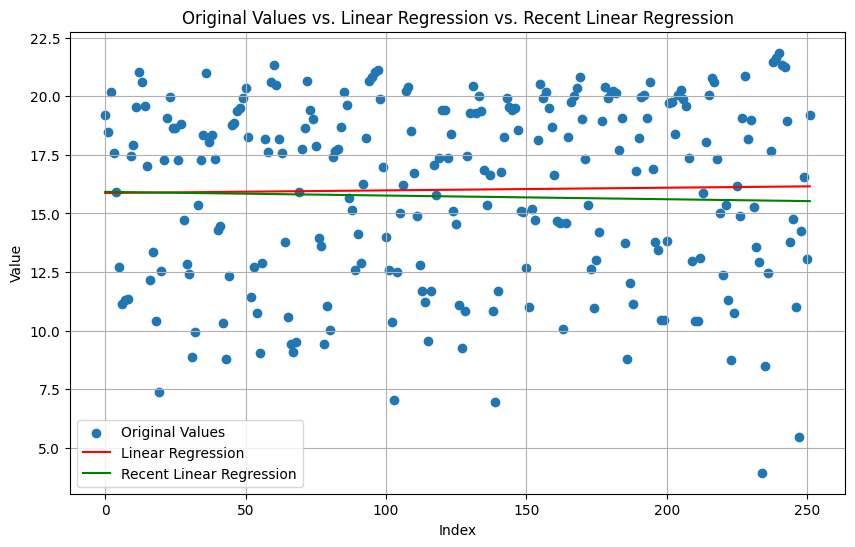

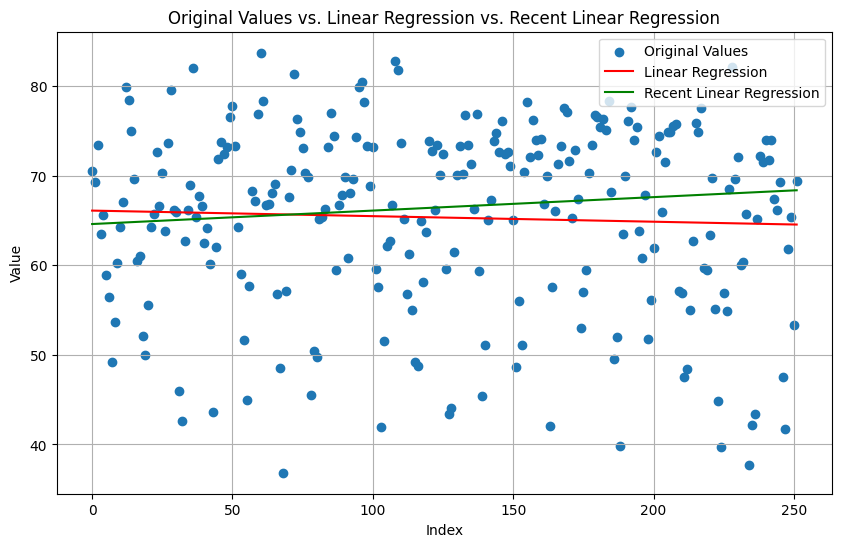

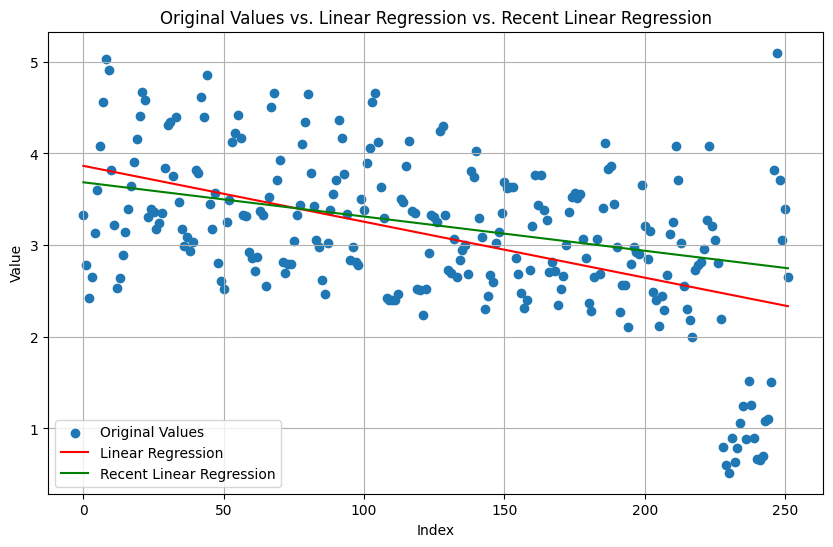

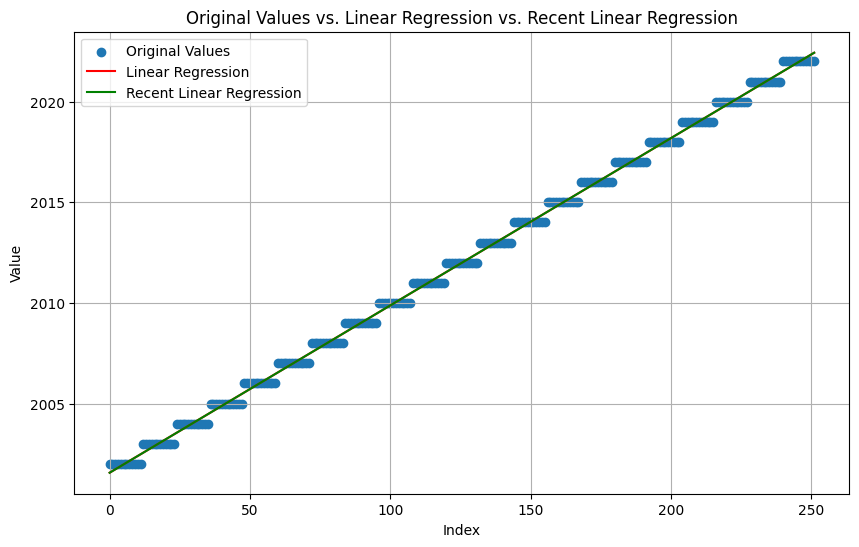

,Ano,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
0,2002,3.021107,951.344152,1563.994302,25.561346,18.859975,69.170674,2.797836,2002.000000
1,2002,3.272872,952.034529,1497.403152,25.134774,18.199505,68.191104,2.757404,2002.000000
2,2002,2.797381,952.847258,1474.156722,24.592026,17.242520,66.458986,2.894637,2002.000000
3,2002,2.949132,953.432444,1414.251609,23.939415,15.950681,64.042511,3.130858,2002.000000
4,2002,2.672603,954.026920,1365.298408,23.500205,14.638504,61.275057,3.450057,2002.000000
...,...,...,...,...,...,...,...,...,...
247,2022,4.373493,954.652542,1458.321342,22.576695,12.863821,57.214383,3.314684,2021.980331
248,2022,3.623370,953.002709,1466.575705,23.500278,14.647649,60.596217,3.135584,2021.986821
249,2022,3.591799,952.579214,1517.963323,23.783083,14.903871,60.578458,3.115871,2021.989698
250,2022,3.774919,952.213351,1546.810547,23.930763,14.935682,60.234187,3.124207,2021.991370


In [8]:
df = read_csv_replace_missing_by_polynomial('mato_grosso_do_sul_variacao_climatica.csv', 0, 1)
df.rename(columns={'Date': 'Ano'}, inplace=True)
df['Ano'] = df['Ano'].str[:4].astype(int)
df.drop(columns='State', inplace=True)
df

In [9]:
import re

df_indexed = df.set_index('Ano')

def correct_index(df):
    new_index = []
    for i, index_value in enumerate(df.index):
        new_index.append(f"{index_value}-{i % 12 + 1}")
    df.index = new_index
    return df

df_indexed = correct_index(df_indexed)
df_indexed = df_indexed.drop('Year', axis=1)
df_indexed

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s)
2002-1,3.021107,951.344152,1563.994302,25.561346,18.859975,69.170674,2.797836
2002-2,3.272872,952.034529,1497.403152,25.134774,18.199505,68.191104,2.757404
2002-3,2.797381,952.847258,1474.156722,24.592026,17.242520,66.458986,2.894637
2002-4,2.949132,953.432444,1414.251609,23.939415,15.950681,64.042511,3.130858
2002-5,2.672603,954.026920,1365.298408,23.500205,14.638504,61.275057,3.450057
...,...,...,...,...,...,...,...
2022-8,4.373493,954.652542,1458.321342,22.576695,12.863821,57.214383,3.314684
2022-9,3.623370,953.002709,1466.575705,23.500278,14.647649,60.596217,3.135584
2022-10,3.591799,952.579214,1517.963323,23.783083,14.903871,60.578458,3.115871
2022-11,3.774919,952.213351,1546.810547,23.930763,14.935682,60.234187,3.124207


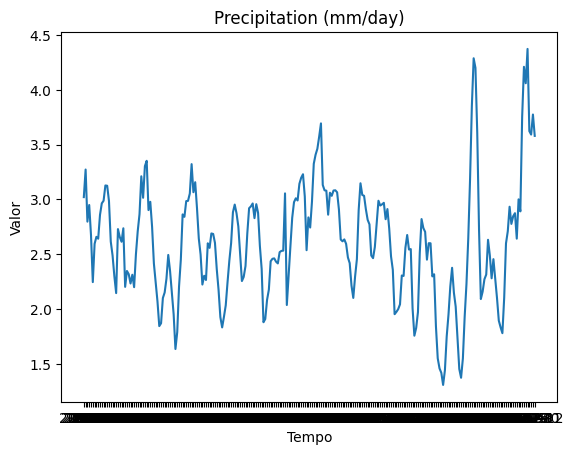

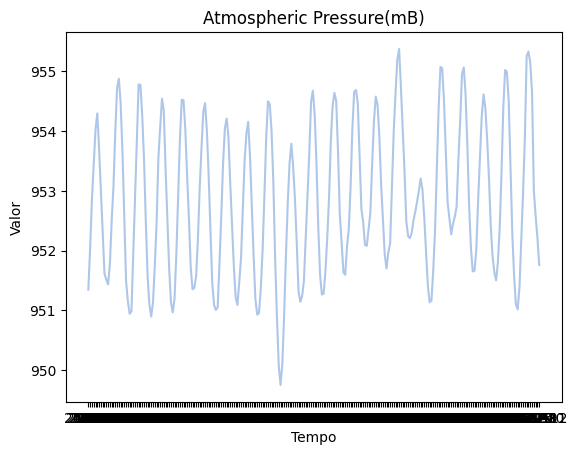

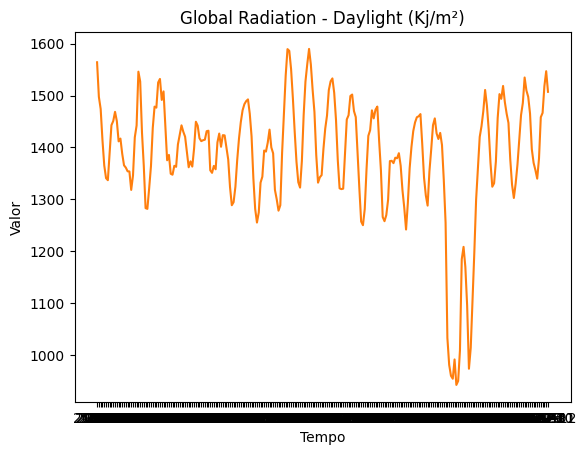

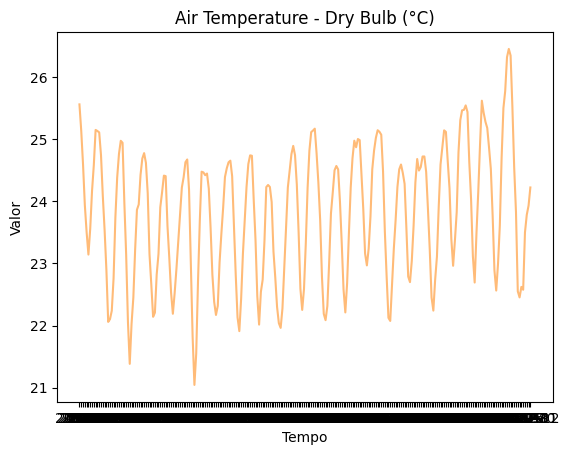

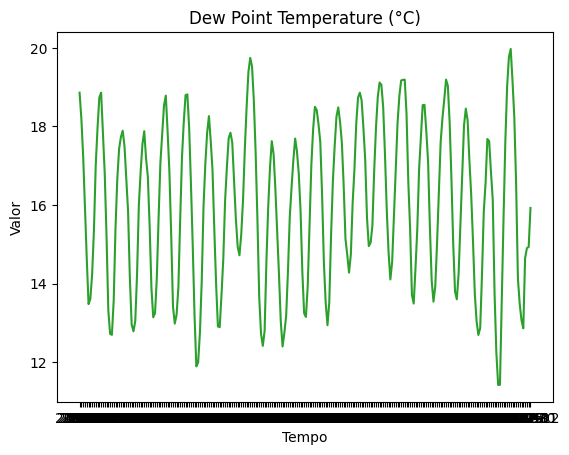

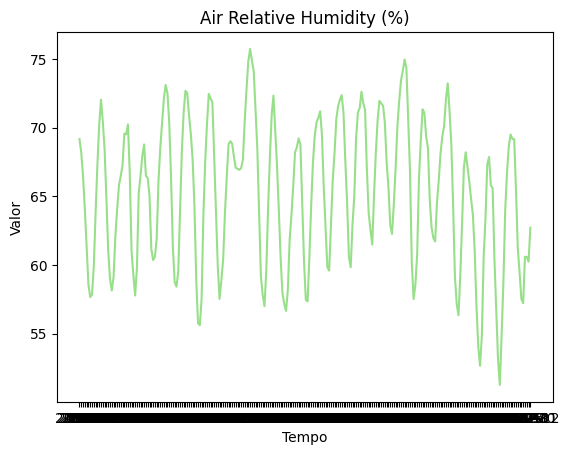

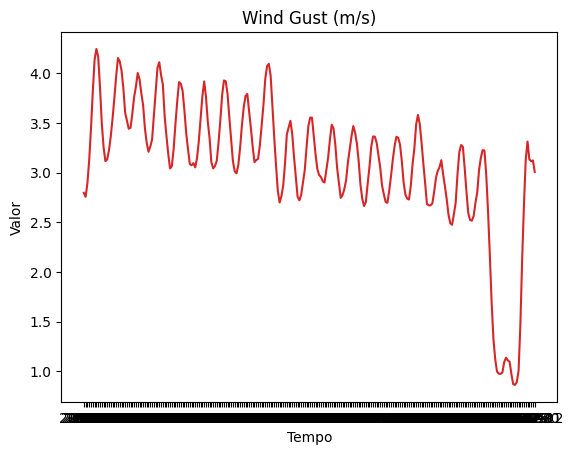

In [10]:
plot_columns(df_indexed)

In [11]:
df_indexed.to_csv('2003_mo_meteo.csv')

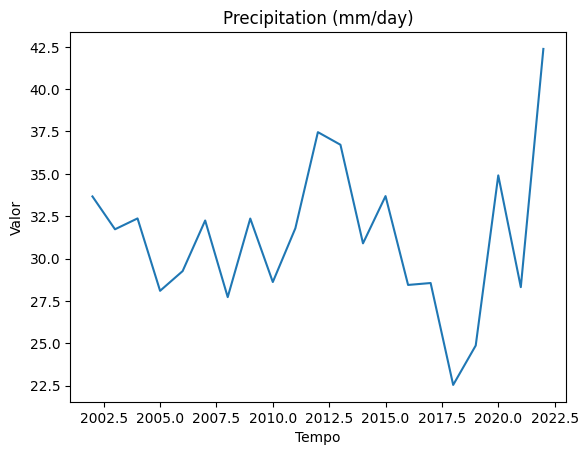

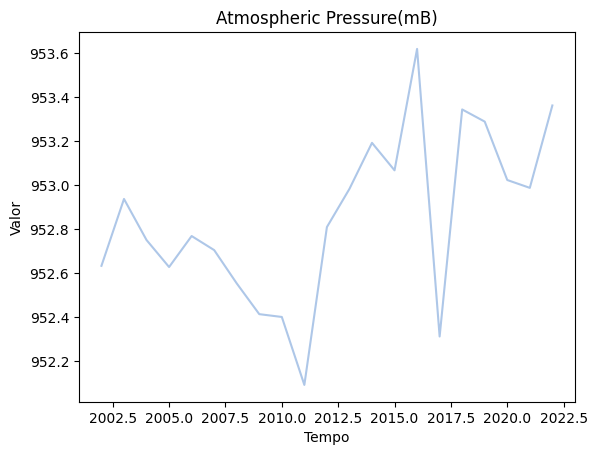

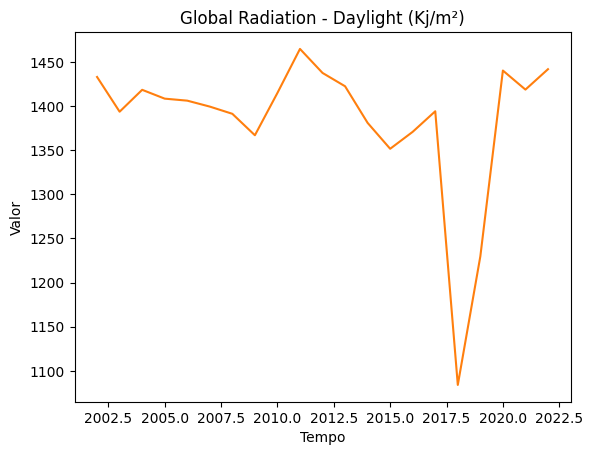

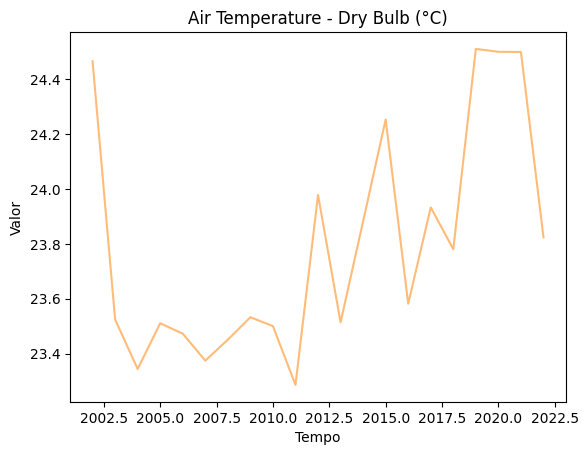

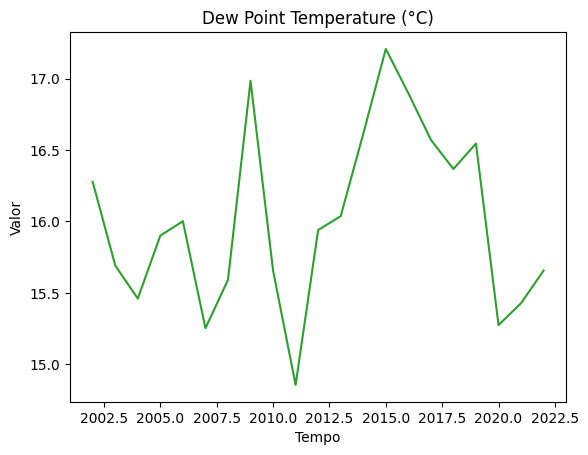

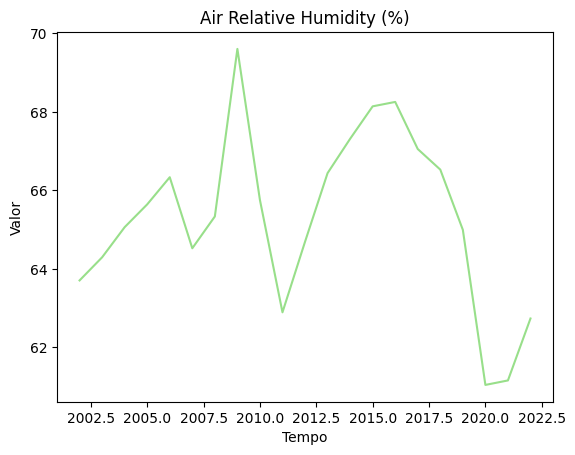

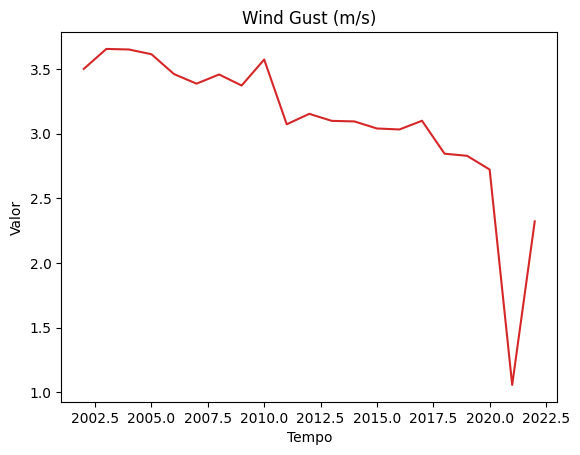

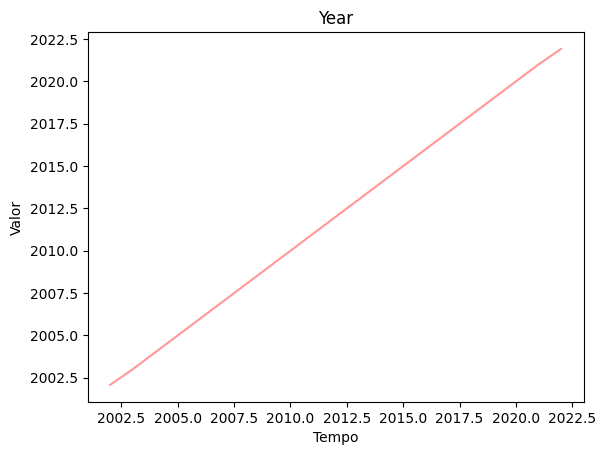

In [12]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year = df_year.groupby('Ano').mean()
df_year['Precipitation (mm/day)'] = df_year['Precipitation (mm/day)'] * 12
plot_columns(df_year)

In [13]:
df_2003 = df_year[df_year.index >= 2003]
df_2003

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2003,31.725691,952.935902,1393.662098,23.524423,15.690980,64.295208,3.656626,2003.000676
2004,32.367041,952.749204,1418.462481,23.344262,15.459343,65.063050,3.652222,2004.000006
2005,28.092159,952.626461,1408.453059,23.510796,15.901025,65.643916,3.615590,2005.000000
2006,29.256637,952.767351,1406.181815,23.473025,16.001342,66.335754,3.461983,2006.000000
2007,32.244267,952.703421,1399.446405,23.374766,15.252106,64.524969,3.387765,2007.000000
2008,27.719747,952.552149,1391.272939,23.451176,15.590231,65.335411,3.458877,2008.000000
2009,32.359665,952.412277,1366.960742,23.532744,16.985602,69.604539,3.373263,2009.000000
2010,28.611401,952.399507,1414.942986,23.500400,15.656432,65.754267,3.574482,2010.000000
2011,31.784134,952.090592,1464.802344,23.286371,14.854536,62.893320,3.073334,2011.000000


In [14]:
df_2003.to_csv('2003_01_meteo.csv', index=True)

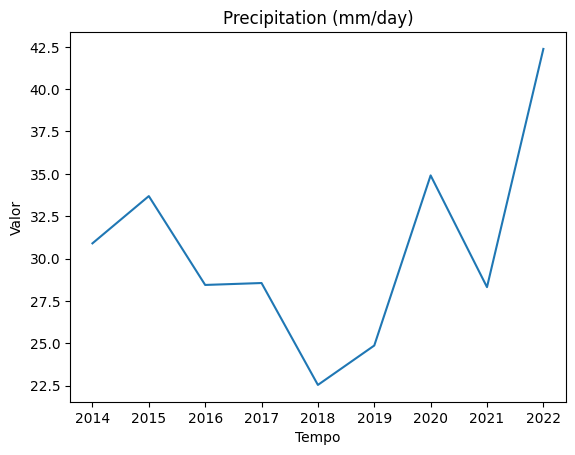

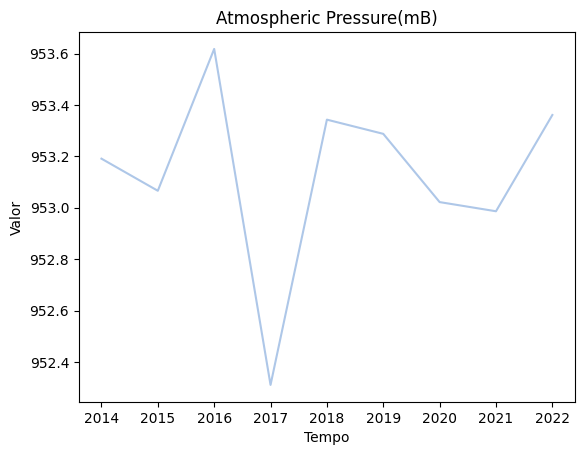

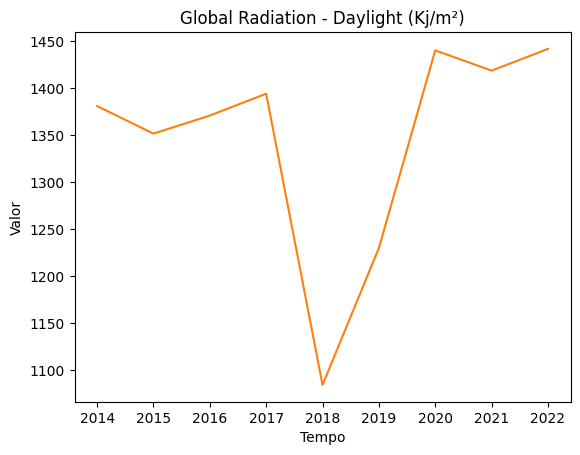

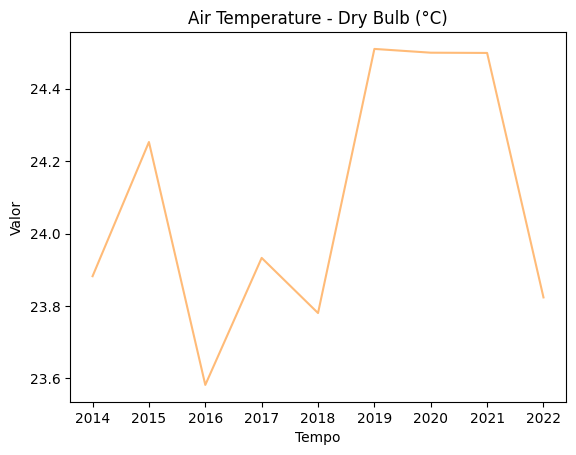

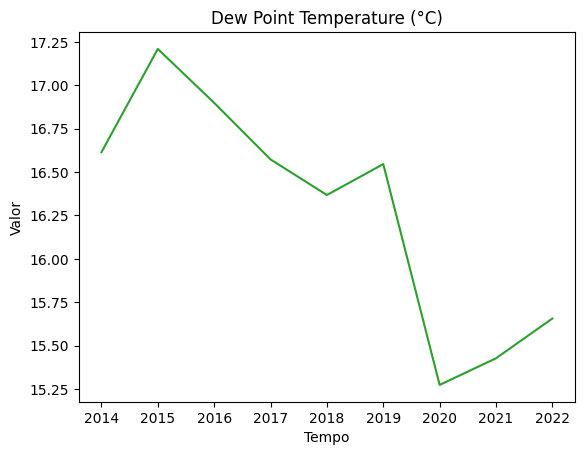

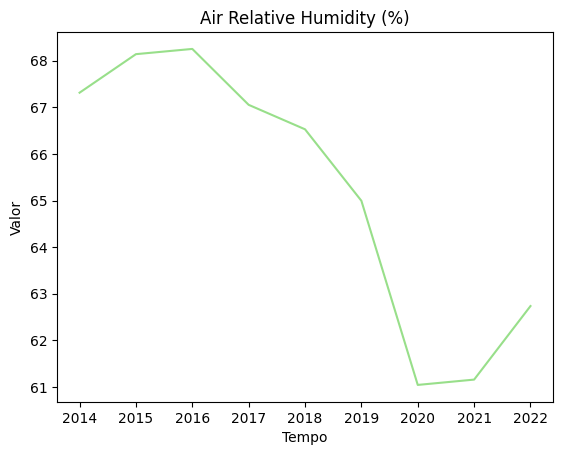

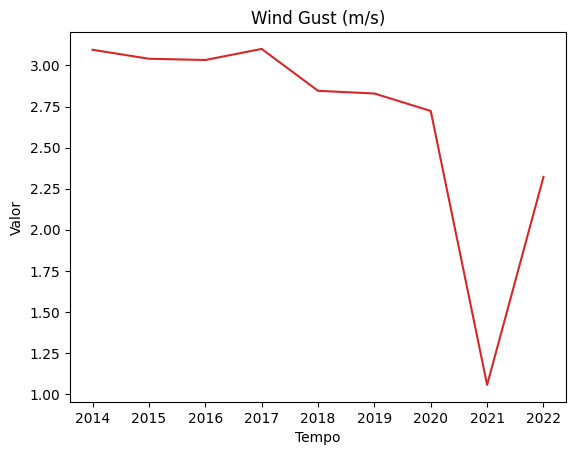

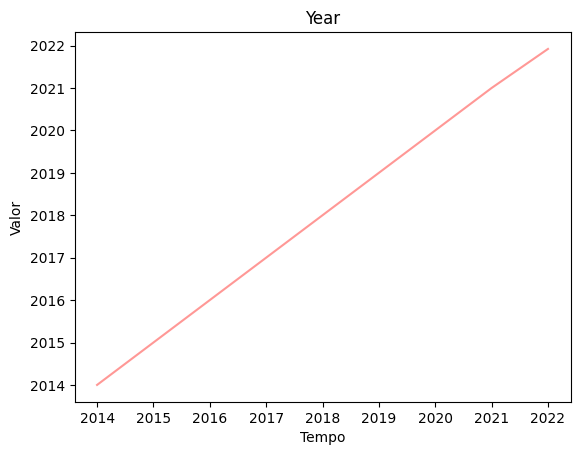

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2014,30.894785,953.190948,1380.997037,23.882114,16.614059,67.314516,3.095445,2014.000000
2015,33.685000,953.066025,1351.644337,24.252563,17.208958,68.141586,3.040814,2015.000000
2016,28.438462,953.617890,1370.870077,23.581975,16.898331,68.253914,3.033226,2016.000000
2017,28.551785,952.310718,1394.147646,23.932640,16.572568,67.054022,3.100639,2017.000000
2018,22.534560,953.342760,1084.050618,23.780374,16.367608,66.528937,2.845698,2018.000000
2019,24.861001,953.287499,1229.822144,24.509575,16.545768,64.994606,2.829301,2019.000000
2020,34.907183,953.021992,1440.291738,24.499165,15.273847,61.043309,2.722966,2020.000000
2021,28.309239,952.986316,1418.718961,24.498471,15.427298,61.157570,1.055933,2021.000000
2022,42.376421,953.360902,1441.828034,23.823583,15.656136,62.735858,2.321831,2021.920844


In [15]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [16]:
df_2014.to_csv('2014_01_meteo.csv', index=True)

In [17]:
df_2008 = df_year[df_year.index >= 2008]
df_2008

,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year
Ano,,,,,,,,
2008,27.719747,952.552149,1391.272939,23.451176,15.590231,65.335411,3.458877,2008.000000
2009,32.359665,952.412277,1366.960742,23.532744,16.985602,69.604539,3.373263,2009.000000
2010,28.611401,952.399507,1414.942986,23.500400,15.656432,65.754267,3.574482,2010.000000
2011,31.784134,952.090592,1464.802344,23.286371,14.854536,62.893320,3.073334,2011.000000
2012,37.461696,952.808039,1437.594896,23.977785,15.939953,64.691144,3.154061,2012.000000
2013,36.717296,952.981783,1422.486158,23.514232,16.037035,66.440062,3.099755,2013.000000
2014,30.894785,953.190948,1380.997037,23.882114,16.614059,67.314516,3.095445,2014.000000
2015,33.685000,953.066025,1351.644337,24.252563,17.208958,68.141586,3.040814,2015.000000
2016,28.438462,953.617890,1370.870077,23.581975,16.898331,68.253914,3.033226,2016.000000


In [18]:
df_2008.to_csv('2008_01_meteo.csv', index=True)